In [1]:
"""
    Student:        Byron Dowling
    Class:          Computer Vision (CSE 60535)
    Term:           University of Notre Dame, Fall 2023
    Assignment:     Practical #3 Task 1 : Image Stitching 3 Images Middle Reference
"""

import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

In [2]:
#############################################################################################
# *** TASKS 0 and 1: read your images here, you may adjust the image path
#############################################################################################

im_left = cv2.imread(r'C:\Users\byron\OneDrive\Documents\Python Stuff\Computer Vision\Images\BigMeadows_3.jpg')
im_middle = cv2.imread(r'C:\Users\byron\OneDrive\Documents\Python Stuff\Computer Vision\Images\BigMeadows_1.jpg')
im_right = cv2.imread(r'C:\Users\byron\OneDrive\Documents\Python Stuff\Computer Vision\Images\BigMeadows_2.jpg')

im_left = cv2.resize(im_left, (640, 480))
im_middle = cv2.resize(im_middle, (640, 480))
im_right = cv2.resize(im_right, (640, 480))

In [3]:
tforms = {}
im_keys = ['left', 'middle', 'right']

#############################################################################################
# *** TASK 1: "im_keys" will need the third key: 'right' -- add it above
#############################################################################################

In [4]:
sift = cv2.SIFT_create(contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)

# Opencv does not automatically handle dimensions of warped images, if the warped results falls outside the image window it will be cutoff
# Thus, here we define a function that will take in the images and the transformation matrices and add appropriate translations to the transformation
# matrices and also provide the panorama dimensions
def getPanoDimsTransl_twoImages(im_left, im_middle, tforms, im_keys):
    border_points = {}
    border_points['left'] = np.float32([[0, 0, 1], [0, im_left.shape[0], 1], \
                            [im_left.shape[1], 0, 1], [im_left.shape[1], im_left.shape[0], 1]])
    border_points['middle'] = np.float32([(0, 0, 1), (0, im_middle.shape[0], 1), \
                            [im_middle.shape[1], 0, 1], [im_middle.shape[1], im_middle.shape[0], 1]])

    # First, we are using transformation matrices to find the warped image border points for each image.
    # We are then using these transformed border points to find the panorama width and height
    warped_border_x = {}
    warped_border_y = {}
    for im_key in im_keys:
        tformed_points = tforms[im_key] @ np.transpose(border_points[im_key])  # matrix multiplication (also works with np.matmul)
        tformed_points = np.transpose(tformed_points)
        warped_border_x[im_key] = list(tformed_points[:, 0]/tformed_points[:,2])
        warped_border_y[im_key] = list(tformed_points[:, 1]/tformed_points[:,2])

    max_widths = {}
    max_heights = {}
    for im_key in im_keys:
        max_widths[im_key] = math.ceil(max(warped_border_x[im_key]) - min(warped_border_x[im_key])) + 1
        max_heights[im_key] = math.ceil(max(warped_border_y[im_key]) - min(warped_border_y[im_key])) + 1

    panorama_width = 0
    panorama_height = 0
    for im_key in im_keys:
        panorama_width += max_widths[im_key]
        if panorama_height < max_heights[im_key]:
            panorama_height = max_heights[im_key]

    # track negative values of x in left image to determine positive translation in x
    # track negative values of y in all images to determine positive translation in y
    x_translation = math.ceil(-min(warped_border_x['left'] + warped_border_x['middle'] ))
    y_translation = math.ceil(-min(warped_border_y['left'] + warped_border_y['middle'] ))

    trans_mat = np.float32([[1, 0, x_translation], [0, 1, y_translation],[0, 0, 1]])

    for im_key in im_keys:
        tforms[im_key] = trans_mat @ tforms[im_key]

    return (panorama_width, panorama_height), tforms

def getPanoDimsTransl_threeImages(im_left, im_middle, im_right, tforms, im_keys):
    border_points = {}
    border_points['left'] = np.float32([[0, 0, 1], [0, im_left.shape[0], 1], \
                            [im_left.shape[1], 0, 1], [im_left.shape[1], im_left.shape[0], 1]])
    border_points['middle'] = np.float32([(0, 0, 1), (0, im_middle.shape[0], 1), \
                            [im_middle.shape[1], 0, 1], [im_middle.shape[1], im_middle.shape[0], 1]])
    border_points['right'] = np.float32([[0, 0, 1], [0, im_right.shape[0], 1], \
                            [im_right.shape[1], 0, 1], [im_right.shape[1], im_right.shape[0], 1]])

    # First, we are using transformation matrices to find the warped image border points for each image.
    # We are then using these transformed border points to find the panorama width and height
    warped_border_x = {}
    warped_border_y = {}
    required_x_translation = 0
    required_y_translation = 0
    for im_key in im_keys:
        tformed_points = tforms[im_key] @ np.transpose(border_points[im_key])  # matrix multiplication (also works with np.matmul)
        tformed_points = np.transpose(tformed_points)
        warped_border_x[im_key] = list(tformed_points[:, 0]/tformed_points[:,2])
        warped_border_y[im_key] = list(tformed_points[:, 1]/tformed_points[:,2])

    max_widths = {}
    max_heights = {}
    for im_key in im_keys:
        max_widths[im_key] = math.ceil(max(warped_border_x[im_key]) - min(warped_border_x[im_key])) + 1
        max_heights[im_key] = math.ceil(max(warped_border_y[im_key]) - min(warped_border_y[im_key])) + 1

    panorama_width = 0
    panorama_height = 0
    for im_key in im_keys:
        panorama_width += max_widths[im_key]
        if panorama_height < max_heights[im_key]:
            panorama_height = max_heights[im_key]

    # track negative values of x in left image to determine positive translation in x
    # track negative values of y in all images to determine positive translation in y
    x_translation = math.ceil(-min(warped_border_x['left'] + warped_border_x['middle'] + warped_border_x['right']))
    y_translation = math.ceil(-min(warped_border_y['left'] + warped_border_y['middle'] + warped_border_y['right']))

    trans_mat = np.float32([[1, 0, x_translation], [0, 1, y_translation],[0, 0, 1]])

    for im_key in im_keys:
        tforms[im_key] = trans_mat @ tforms[im_key]

    return (panorama_width, panorama_height), tforms

# Interpolation can cause noise at the borders, using masks to remove some pixels from the border (not required if you use INTER_NEAREST as flags)
def getErodedWarpedIm_twoImages(warped_im_left, warped_im_middle):
    kernel = np.ones((3, 3),np.uint8)
    erosion_mask_left = cv2.erode(cv2.warpPerspective(np.ones(im_left.shape[:2], dtype="uint8") * 255, tforms['left'], (panorama_width, panorama_height), flags=cv2.INTER_NEAREST), kernel)
    warped_im_left = cv2.bitwise_and(warped_im_left, warped_im_left, mask=erosion_mask_left)
    erosion_mask_middle = cv2.erode(cv2.warpPerspective(np.ones(im_middle.shape[:2], dtype="uint8") * 255, tforms['middle'], (panorama_width, panorama_height), flags=cv2.INTER_NEAREST), kernel)
    warped_im_middle = cv2.bitwise_and(warped_im_middle, warped_im_middle, mask=erosion_mask_middle)
    return warped_im_left, warped_im_middle

def getErodedWarpedIm_threeImages(warped_im_left, warped_im_middle, warped_im_right):
    kernel = np.ones((3, 3),np.uint8)
    erosion_mask_left = cv2.erode(cv2.warpPerspective(np.ones(im_left.shape[:2], dtype="uint8") * 255, tforms['left'], (panorama_width, panorama_height), flags=cv2.INTER_NEAREST), kernel)
    warped_im_left = cv2.bitwise_and(warped_im_left, warped_im_left, mask=erosion_mask_left)
    erosion_mask_middle = cv2.erode(cv2.warpPerspective(np.ones(im_middle.shape[:2], dtype="uint8") * 255, tforms['middle'], (panorama_width, panorama_height), flags=cv2.INTER_NEAREST), kernel)
    warped_im_middle = cv2.bitwise_and(warped_im_middle, warped_im_middle, mask=erosion_mask_middle)
    erosion_mask_right = cv2.erode(cv2.warpPerspective(np.ones(im_right.shape[:2], dtype="uint8") * 255, tforms['right'], (panorama_width, panorama_height), flags=cv2.INTER_NEAREST), kernel)
    warped_im_right = cv2.bitwise_and(warped_im_right, warped_im_right, mask=erosion_mask_right)
    return warped_im_left, warped_im_middle, warped_im_right

In [5]:
# Find SIFT keypoints and descriptors for the left image
grayImage_left = cv2.cvtColor(im_left, cv2.COLOR_BGR2GRAY)
keypoints_left, descriptors_left = sift.detectAndCompute(grayImage_left, None)

# Find SIFT keypoints and descriptors for the middle image
grayImage_middle = cv2.cvtColor(im_middle, cv2.COLOR_BGR2GRAY)
keypoints_middle, descriptors_middle = sift.detectAndCompute(grayImage_middle, None)

#############################################################################################
# *** TASK 1: Add the code here to find SIFT keypoints and descriptors for the RIGHT image:
#############################################################################################
grayImage_right = cv2.cvtColor(im_right, cv2.COLOR_BGR2GRAY)
keypoints_right, descriptors_right = sift.detectAndCompute(grayImage_right, None)

In [6]:
# Match keypoints between the left and the middle image using SIFT descriptors
bf = cv2.BFMatcher(crossCheck=True)
matches_ml = bf.match(descriptors_middle,descriptors_left)

#############################################################################################
# *** TASK 1: Add the code here to match keypoints between the middle and the RIGHT image
#############################################################################################
matches_rm = bf.match(descriptors_middle, descriptors_right)

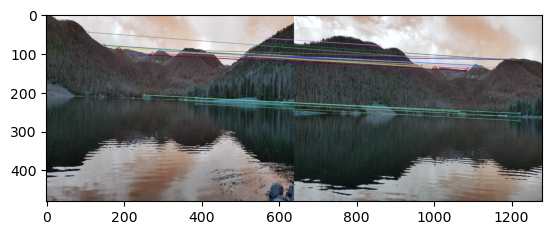

In [8]:
matches_ml_sorted = sorted(matches_ml, key = lambda x:x.distance)
match_shape = (im_middle.shape[0]+im_left.shape[0],im_middle.shape[1]+im_left.shape[1])
match_img = np.zeros(match_shape)
match_img = cv2.drawMatches(im_middle, keypoints_middle, im_left, keypoints_left, matches_ml_sorted[:20], match_img, flags=2)
plt.imshow(match_img)

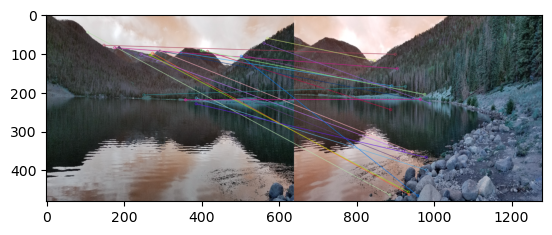

In [9]:
matches_rm_sorted = sorted(matches_ml, key = lambda x:x.distance)
match_shape = (im_middle.shape[0]+im_right.shape[0],im_middle.shape[1]+im_right.shape[1])
match_img = np.zeros(match_shape)
match_img = cv2.drawMatches(im_middle, keypoints_middle, im_right, keypoints_right, matches_rm_sorted[:20], match_img, flags=2)
plt.imshow(match_img)

In [15]:
# Find matching points between the left and the middle image from the DMatcher objects
if len(matches_ml) >= 4:
    middle_points = np.float32([ keypoints_middle[m.queryIdx].pt for m in matches_ml ]).reshape(-1,1,2)
    left_points = np.float32([ keypoints_left[m.trainIdx].pt for m in matches_ml ]).reshape(-1,1,2)
else:
    print('Images are too different, less than 4 keypoint matches found.')
    exit()

#############################################################################################
# *** TASK 1: Add the code here to find matching points between the middle and the RIGHT image
#############################################################################################

if len(matches_rm) >= 4:
    middle_points_new = np.float32([ keypoints_middle[m.queryIdx].pt for m in matches_rm]).reshape(-1,1,2)
    right_points = np.float32([ keypoints_right[m.trainIdx].pt for m in matches_rm]).reshape(-1,1,2)
else:
    print('Images are too different, less than 4 keypoint matches found.')
    exit()

In [24]:
# For the left image, the transformation matrix is an identity matrix:
tforms['middle'] = np.identity(3)

# For the middle image, the projective transformation matrix is calculated with the use
# of the corresponding (matching) SIFT keypoints between the left and the middle image:
H1, masked = cv2.findHomography(left_points, middle_points, cv2.RANSAC, 5.0)
tforms['left'] = H1

In [25]:
#############################################################################################
# *** TASK 1: Add the code here to:
# -- get projective transformation matrix for your RIGHT image
# -- assign it to tforms['right'] (add 'right' to "im_keys")
# Tip: you will need here both tforms['middle'] and your newly calculated H matrix
#############################################################################################

H2, masked = cv2.findHomography(right_points, middle_points_new, cv2.RANSAC, 5.0)

tforms['right'] = tforms['middle'] @ H2

In [26]:
#############################################################################################
# *** TASK 1: use getPanoDimsTransl_threeImages() instead of getPanoDimsTransl_twoImages()
#
# function parameters:
# def getPanoDimsTransl_threeImages(im_left, im_middle, im_right, tforms, im_keys):
#
#############################################################################################

(panorama_width, panorama_height), tforms = getPanoDimsTransl_threeImages(im_left, im_middle, im_right, tforms, im_keys)

# Warp the images using projective transformation matrices (keep max x and max y as space for both images)
warped_im_left = cv2.warpPerspective(im_left, tforms['left'], (panorama_width, panorama_height))
warped_im_middle = cv2.warpPerspective(im_middle, tforms['middle'], (panorama_width, panorama_height))
warped_im_right = cv2.warpPerspective(im_middle, tforms['right'], (panorama_width, panorama_height))

#############################################################################################
# *** TASK 1: use getPanoDimsTransl_threeImages() and getErodedWarpedIm_threeImages()
#             instead of getPanoDimsTransl_twoImages() and getErodedWarpedIm_twoImages()
# Function definition:
# def getErodedWarpedIm_threeImages(warped_im_left, warped_im_middle, warped_im_right):
#
#############################################################################################

warped_im_left, warped_im_middle, warped_im_right = getErodedWarpedIm_threeImages(warped_im_left, warped_im_middle, warped_im_right)

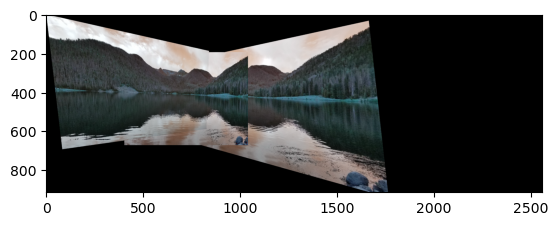

In [27]:
stitched_im = warped_im_left
np.copyto(stitched_im, warped_im_middle, where = stitched_im == 0)

#############################################################################################
# *** TASK 1: Almost there! Last thing: add yet another "np.copyto" line to add your warped
#             right image to your stitched imaged (stitched_im)
#############################################################################################
np.copyto(stitched_im, warped_im_right, where = stitched_im == 0)

plt.imshow(stitched_im)